# SPX price prediction

In [1]:
from google.colab import files
uploaded = files.upload()


Saving yahoo_SPX.csv to yahoo_SPX.csv
Saving yahoo_NDX.csv to yahoo_NDX.csv
Saving yahoo_ETH.csv to yahoo_ETH.csv
Saving yahoo_DJIA.csv to yahoo_DJIA.csv
Saving yahoo_BTC.csv to yahoo_BTC.csv
Saving yahoo_BNB.csv to yahoo_BNB.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [11]:
# Load the datasets
btc = pd.read_csv('yahoo_BTC.csv')
eth = pd.read_csv('yahoo_ETH.csv')
bnb = pd.read_csv('yahoo_BNB.csv')
spx = pd.read_csv('yahoo_SPX.csv')

In [12]:
# Preprocess the data
# Convert the Date column to datetime
for df in [btc, eth, bnb, spx]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge the datasets on Date, including all relevant features (Open, High, Low, Close, Volume)
merged_spx = btc[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
    'Open': 'BTC_Open', 'High': 'BTC_High', 'Low': 'BTC_Low', 'Close': 'BTC_Close', 'Volume': 'BTC_Volume'})
merged_spx = merged_spx.merge(
    eth[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'ETH_Open', 'High': 'ETH_High', 'Low': 'ETH_Low', 'Close': 'ETH_Close',  'Volume': 'ETH_Volume'}), on='Date')
merged_spx = merged_spx.merge(
    bnb[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'BNB_Open', 'High': 'BNB_High', 'Low': 'BNB_Low', 'Close': 'BNB_Close',  'Volume': 'BNB_Volume'}), on='Date')
merged_spx = merged_spx.merge(
    spx[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'SPX_Open', 'High': 'SPX_High', 'Low': 'SPX_Low', 'Close': 'SPX_Close',  'Volume': 'SPX_Volume'}), on='Date')

# Sort the data by the 'Date' column in ascending order
merged_spx = merged_spx.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_spx.dropna(inplace=True)

# Normalize the data
scaler_spx = MinMaxScaler()
scaled_spx = scaler_spx.fit_transform(merged_spx.drop(columns=['Date']))

In [13]:
merged_spx.tail()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,ETH_Open,ETH_High,ETH_Low,ETH_Close,...,BNB_Open,BNB_High,BNB_Low,BNB_Close,BNB_Volume,SPX_Open,SPX_High,SPX_Low,SPX_Close,SPX_Volume
1695,2024-08-08,55030.027344,62673.765625,54766.726562,61710.136719,45298472567,2336.915039,2721.954590,2322.529541,2683.352783,...,474.199707,521.040466,469.190674,517.337524,1790085695,5252.569824,5328.029785,5233.850098,5319.310059,4016830000
1696,2024-08-09,61728.207031,61751.863281,59587.859375,60880.113281,33425553115,2683.719971,2706.451172,2555.229492,2599.598633,...,517.337524,517.723145,500.176117,509.182709,1565495419,5314.660156,5358.669922,5300.839844,5344.160156,3516400000
1697,2024-08-12,58719.394531,60680.332031,57688.898438,59354.515625,37078637820,2553.496582,2749.135010,2513.394043,2724.431885,...,503.804169,523.544617,500.233704,518.536133,1786263873,5351.879883,5371.200195,5324.370117,5344.390137,3360160000
1698,2024-08-13,59356.207031,61572.398438,58506.253906,60609.566406,30327698167,2724.303467,2737.990479,2613.801270,2703.671875,...,518.536133,525.686523,514.547546,524.128540,1757981177,5376.979980,5436.500000,5376.979980,5434.430176,3648980000
1699,2024-08-14,60611.050781,61687.757812,58472.875000,58737.269531,29961696180,2703.586914,2775.281006,2636.705322,2662.914795,...,524.128540,531.505188,516.506348,524.015320,1604400640,5442.359863,5463.220215,5415.910156,5455.209961,3380050000


In [14]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-5]  # Use all features except SPX variables
        y = data[i+sequence_length, -2]  # Target is SPX_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  # Number of days to look back
X, y = create_sequences(scaled_spx, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [15]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=32, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=16, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9395 - val_loss: 0.9455
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8246 - val_loss: 0.7826
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7488 - val_loss: 0.7014
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7073 - val_loss: 0.6722
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6780 - val_loss: 0.6447
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6495 - val_loss: 0.6377
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6252 - val_loss: 0.6088
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6071 - val_loss: 0.5881
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5845 - val_loss: 0.5716
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5644 - val_loss: 0.5544
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5474 - val_loss: 0.5298
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

In [17]:

# Create a placeholder for inverse transformation
predicted_spx_full = np.zeros((predictions.shape[0], scaled_spx.shape[1]))
actual_spx_full = np.zeros((y_test.shape[0], scaled_spx.shape[1]))

# Fill the placeholder with predicted values (only for the SPX_Close column)
predicted_spx_full[:, -2] = predictions[:, 0]
actual_spx_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted_spx = scaler_spx.inverse_transform(predicted_spx_full)[:, -2]
actual_spx = scaler_spx.inverse_transform(actual_spx_full)[:, -2]

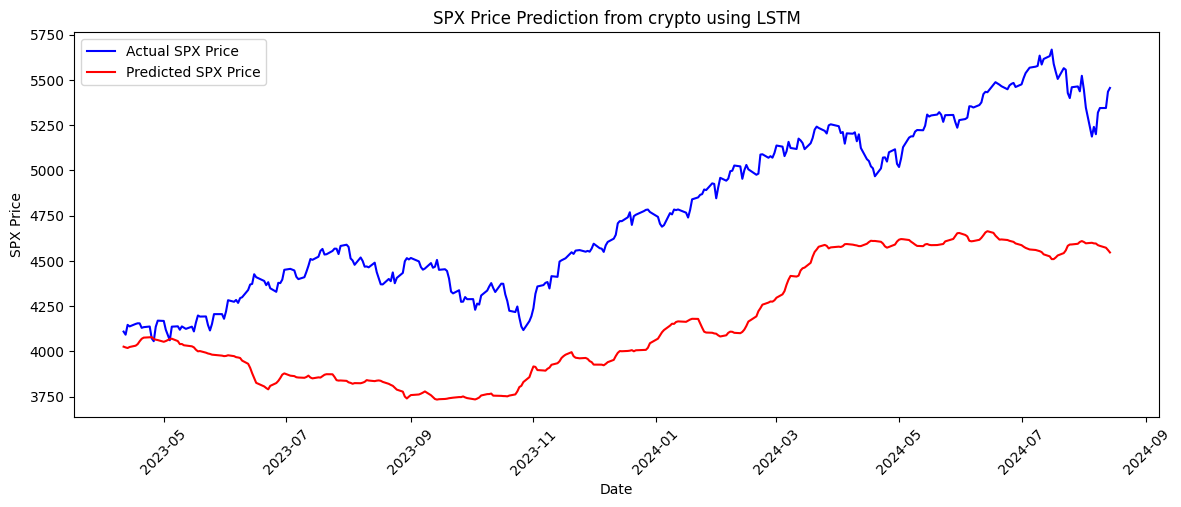

In [18]:
# Create a date range for the test set
test_dates = merged_spx['Date'].iloc[split_index + sequence_length:].values

# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_spx, color='blue', label='Actual SPX Price')
plt.plot(test_dates, predicted_spx, color='red', label='Predicted SPX Price')
plt.title('SPX Price Prediction from crypto using LSTM')
plt.xlabel('Date')
plt.ylabel('SPX Price')
plt.xticks(rotation=45)  
plt.legend()
plt.show()


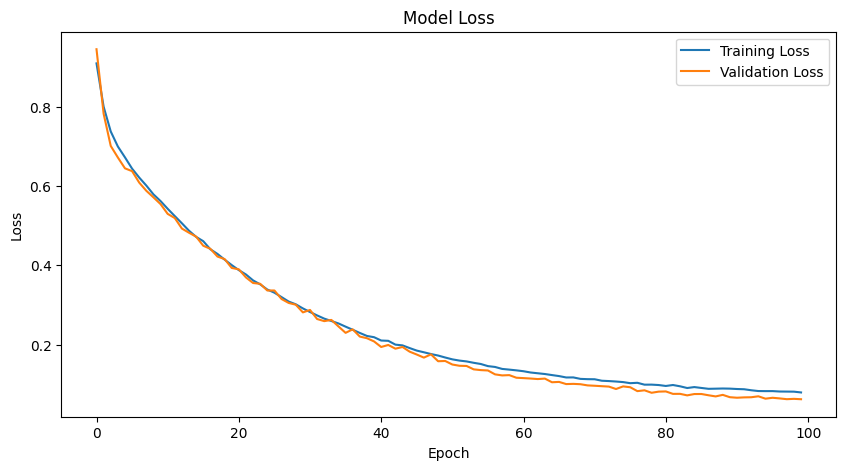

In [19]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# DOW JONES INDUSTRIAL AVG Prediction

# All features

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

In [21]:
# Load the datasets
btc = pd.read_csv('yahoo_BTC.csv')
eth = pd.read_csv('yahoo_ETH.csv')
bnb = pd.read_csv('yahoo_BNB.csv')
dow = pd.read_csv('yahoo_DJIA.csv')

In [22]:
# Preprocess the data
# Convert the Date column to datetime
for df in [btc, eth, bnb, dow]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge the datasets on Date, including all relevant features (Open, High, Low, Close, Volume)
merged_dow = btc[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
    'Open': 'BTC_Open', 'High': 'BTC_High', 'Low': 'BTC_Low', 'Close': 'BTC_Close', 'Volume': 'BTC_Volume'})
merged_dow = merged_dow.merge(
    eth[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'ETH_Open', 'High': 'ETH_High', 'Low': 'ETH_Low', 'Close': 'ETH_Close',  'Volume': 'ETH_Volume'}), on='Date')
merged_dow = merged_dow.merge(
    bnb[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'BNB_Open', 'High': 'BNB_High', 'Low': 'BNB_Low', 'Close': 'BNB_Close',  'Volume': 'BNB_Volume'}), on='Date')
merged_dow = merged_dow.merge(
    dow[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'DOW_Open', 'High': 'DOW_High', 'Low': 'DOW_Low', 'Close': 'DOW_Close',  'Volume': 'DOW_Volume'}), on='Date')

# Sort the data by the 'Date' column in ascending order
merged_dow = merged_dow.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_dow.dropna(inplace=True)

# Normalize the data
scaler_dow = MinMaxScaler()
scaled_dow = scaler_dow.fit_transform(merged_dow.drop(columns=['Date']))

In [23]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-5]  # Use all features except DOW variables
        y = data[i+sequence_length, -2]  # Target is DOW_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  # Number of days to look back
X, y = create_sequences(scaled_dow, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [24]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=32, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=16, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0970 - val_loss: 1.1542
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0016 - val_loss: 0.9801
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8729 - val_loss: 0.7789
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7769 - val_loss: 0.6877
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7291 - val_loss: 0.6564
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6842 - val_loss: 0.6359
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6507 - val_loss: 0.6077
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6197 - val_loss: 0.5892
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5945 - val_loss: 0.5662
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5792 - val_loss: 0.5504
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5573 - val_loss: 0.5339
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

In [26]:


# Create a placeholder for inverse transformation
predicted_dow_full = np.zeros((predictions.shape[0], scaled_dow.shape[1]))
actual_dow_full = np.zeros((y_test.shape[0], scaled_dow.shape[1]))

# Fill the placeholder with predicted values (only for the DOW_Close column)
predicted_dow_full[:, -2] = predictions[:, 0]
actual_dow_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted_dow = scaler_dow.inverse_transform(predicted_dow_full)[:, -2]
actual_dow = scaler_dow.inverse_transform(actual_dow_full)[:, -2]

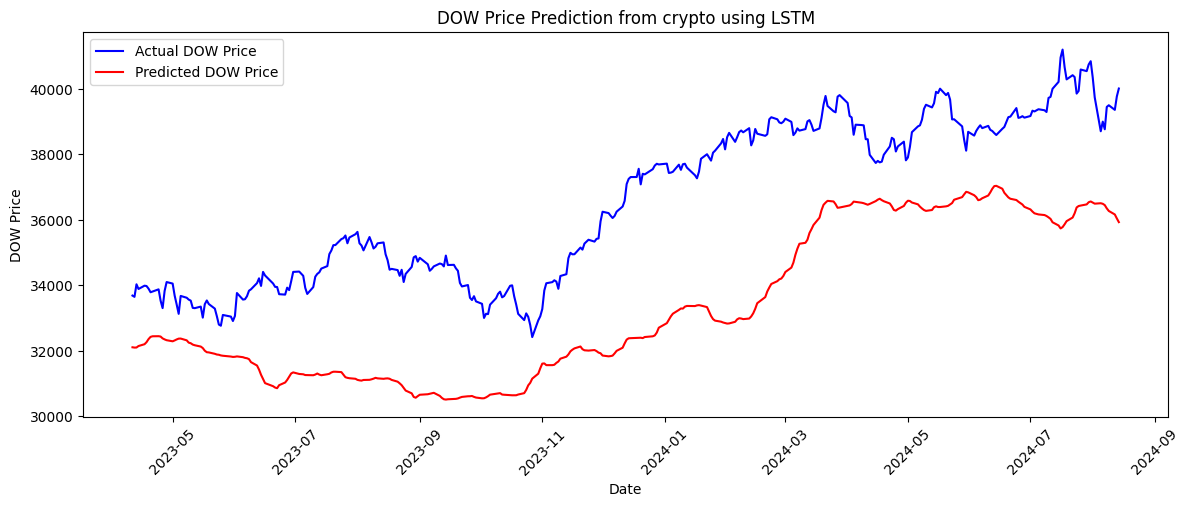

In [27]:
# Create a date range for the test set
test_dates = merged_dow['Date'].iloc[split_index + sequence_length:].values

# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_dow, color='blue', label='Actual DOW Price')
plt.plot(test_dates, predicted_dow, color='red', label='Predicted DOW Price')
plt.title('DOW Price Prediction from crypto using LSTM')
plt.xlabel('Date')
plt.ylabel('DOW Price')
plt.xticks(rotation=45) 
plt.legend()
plt.show()


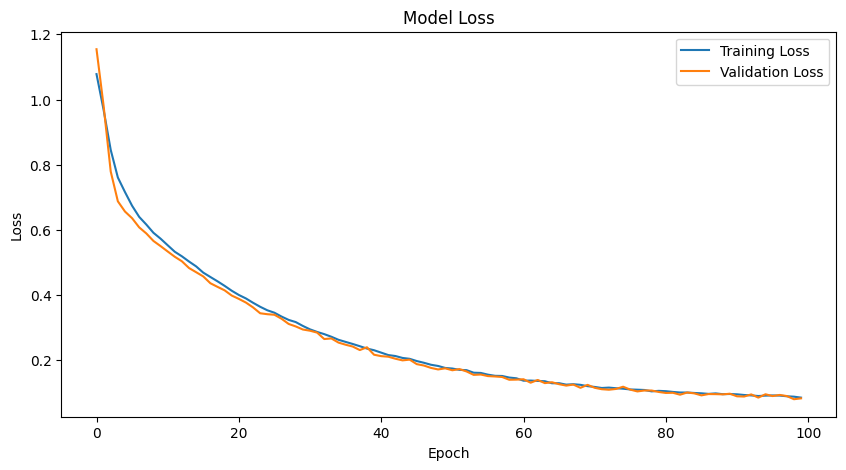

In [28]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# NDX price prediction

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

In [30]:

# Load datasets
btc_data = pd.read_csv('yahoo_BTC.csv')
eth_data = pd.read_csv('yahoo_ETH.csv')
bnb_data = pd.read_csv('yahoo_BNB.csv')
ndx_data = pd.read_csv('yahoo_NDX.csv')



In [31]:
# Preprocess the data
# Convert the Date column to datetime
for df in [btc_data, eth_data, bnb_data, ndx_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge the datasets on Date, including all relevant features (Open, High, Low, Close, Volume)
merged_data = btc_data[['Date', 'Open', 'High', 'Low', 'Close','Volume']].rename(columns={
    'Open': 'BTC_Open', 'High': 'BTC_High', 'Low': 'BTC_Low', 'Close': 'BTC_Close', 'Volume': 'BTC_Volume'})
merged_data = merged_data.merge(
    eth_data[['Date', 'Open', 'High', 'Low', 'Close','Volume']].rename(columns={
        'Open': 'ETH_Open', 'High': 'ETH_High', 'Low': 'ETH_Low', 'Close': 'ETH_Close', 'Volume': 'ETH_Volume'}), on='Date')
merged_data = merged_data.merge(
    bnb_data[['Date', 'Open', 'High', 'Low', 'Close','Volume']].rename(columns={
        'Open': 'BNB_Open', 'High': 'BNB_High', 'Low': 'BNB_Low', 'Close': 'BNB_Close', 'Volume': 'BNB_Volume'}), on='Date')
merged_data = merged_data.merge(
    ndx_data[['Date', 'Open', 'High', 'Low', 'Close','Volume']].rename(columns={
        'Open': 'NDX_Open', 'High': 'NDX_High', 'Low': 'NDX_Low', 'Close': 'NDX_Close', 'Volume': 'NDX_Volume'}), on='Date')



# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler_ndx = MinMaxScaler()
scaled_data = scaler_ndx.fit_transform(merged_data.drop(columns=['Date']))

In [ ]:
merged_data.head()

In [32]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-5]  # Use all features except NDX variables
        y = data[i+sequence_length, -2]  # Target is NDX_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7 
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [33]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=32, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=16, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.9146 - val_loss: 0.9565
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8224 - val_loss: 0.7913
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7364 - val_loss: 0.6824
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7001 - val_loss: 0.6483
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6791 - val_loss: 0.6380
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6554 - val_loss: 0.6042
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6360 - val_loss: 0.5838
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6175 - val_loss: 0.5680
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5913 - val_loss: 0.5454
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5729 - val_loss: 0.5277
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5545 - val_loss: 0.5125
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

In [35]:

# Create a placeholder for inverse transformation
predicted_ndx_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_ndx_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the NDX_Close column)
predicted_ndx_full[:, -2] = predictions[:, 0]
actual_ndx_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted_ndx = scaler_ndx.inverse_transform(predicted_ndx_full)[:, -2]
actual_ndx = scaler_ndx.inverse_transform(actual_ndx_full)[:, -2]


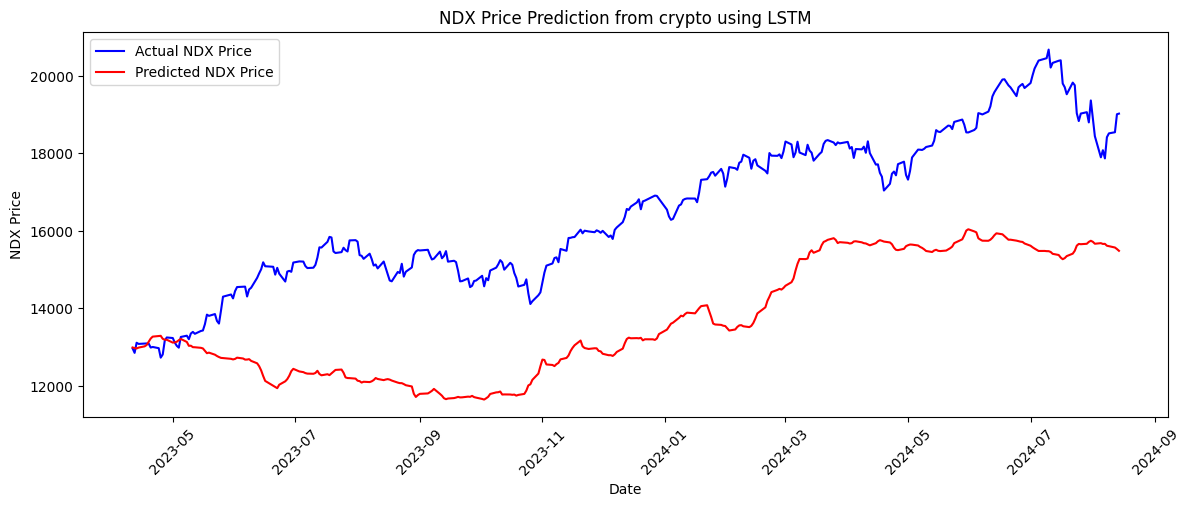

In [36]:
# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values

# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_ndx, color='blue', label='Actual NDX Price')
plt.plot(test_dates, predicted_ndx, color='red', label='Predicted NDX Price')
plt.title('NDX Price Prediction from crypto using LSTM')
plt.xlabel('Date')
plt.ylabel('NDX Price')
plt.xticks(rotation=45) 
plt.legend()
plt.show()


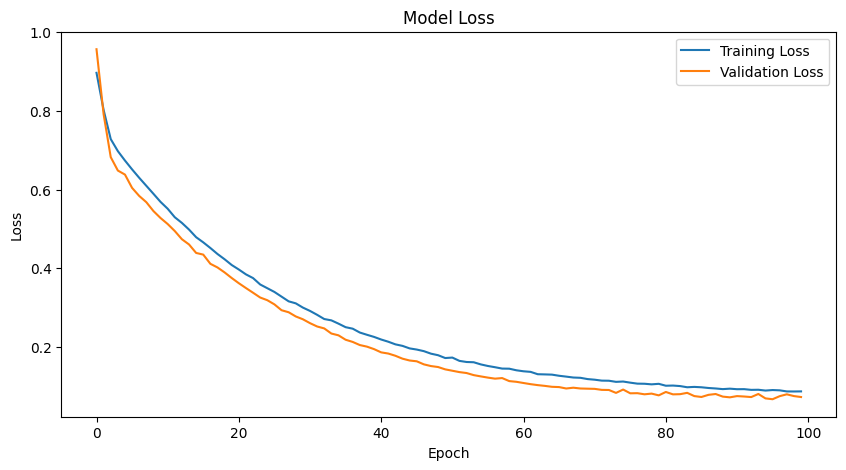

In [37]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()